In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score,precision_score,classification_report,roc_curve,roc_auc_score,auc,confusion_matrix,recall_score
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

This dataset contains data about women, with some features that describe whether a woman got diabetes or not. I am going to run 2 machine learning algorithms on this dataset, to see if I can predict if a woman has diabetes based on her characteristics

In [2]:
data = pd.read_csv('diabetes.csv')
labels = data['Outcome']
data.drop('Outcome',inplace=True,axis=1)

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
dtypes: float64(2), int64(6)
memory usage: 48.1 KB


Replacing 0 values with nan values, since these values can skew the data

In [5]:

data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

Imputing missing data

In [6]:
data['Glucose'].fillna(data['Glucose'].mean(), inplace = True)
data['BloodPressure'].fillna(data['BloodPressure'].mean(), inplace = True)
data['SkinThickness'].fillna(data['SkinThickness'].median(), inplace = True)
data['Insulin'].fillna(data['Insulin'].median(), inplace = True)
data['BMI'].fillna(data['BMI'].median(), inplace = True)

Using Cross Validation to split the dataset in a train and test set, and to evaluate it later in the process

In [7]:
train,test,train_labels,test_labels = train_test_split(data,labels,test_size=0.3,random_state=21,stratify=labels)

Hyperparameter tuning, using RandomSearch, to find the best possible parameters to configure the model in the best way possible

In [ ]:
clf = svm.SVC()
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'degree': np.linspace(2, 5, 4),
          'C': np.logspace(-3, 5, 17),
          'gamma': np.logspace(-3, 5, 17)}

rs = random_search = RandomizedSearchCV(
    estimator=clf, param_distributions=params, n_iter=5, n_jobs=-1,
    cv=5)

rs.fit(train, train_labels)

Checking to see what the best parameters are

In [ ]:
rs.best_params_

Checking to see the difference between train, and test accuracy, to see if the model is overfitting or underfitting

In [8]:
clf = svm.SVC(kernel='linear',probability=True,degree = 5.0,
 gamma = 3.1622776601683795,)
clf.fit(train,train_labels).score(train,train_labels)

0.7858472998137802

In [9]:
clf.fit(test,test_labels).score(test,test_labels)

0.7402597402597403

Plotting a confusion matrix, to see how good the model predicts positives and negatives

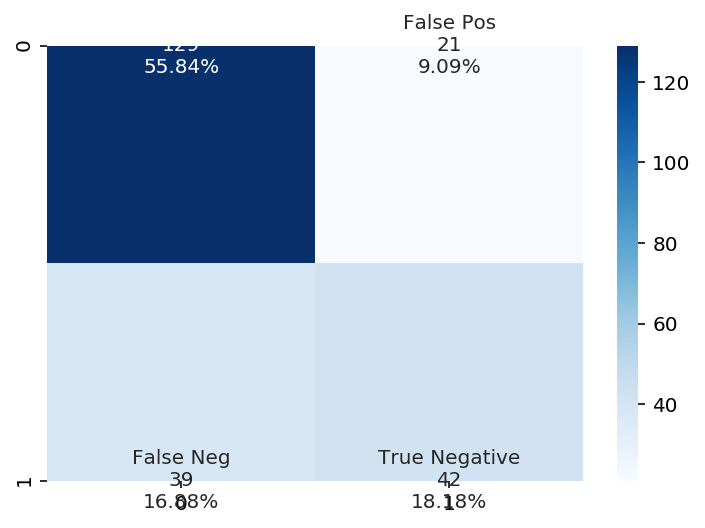

In [10]:
cm = confusion_matrix(test_labels, clf.predict(test)) 
group_names = ['True Neg','False Pos','False Neg','True Negative']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')



It seems the model is quite good at predicting True Positives(If someone does not have diabetes). 

This code, draws an ROC curve, to see the difference between the true positive rate, and the false positive rate

In [11]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
  
    baseline = {}
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [12]:
train_svm_predictions = clf.predict(train)
train_svm_probs = clf.predict_proba(train)[:,1]
test_svm_predictions = clf.predict(test)
test_svm_probs = clf.predict_proba(test)[:,1]

Recall Baseline: 1.0 Test: 0.52 Train: 0.64
Precision Baseline: 0.35 Test: 0.67 Train: 0.7
Roc Baseline: 0.5 Test: 0.83 Train: 0.84


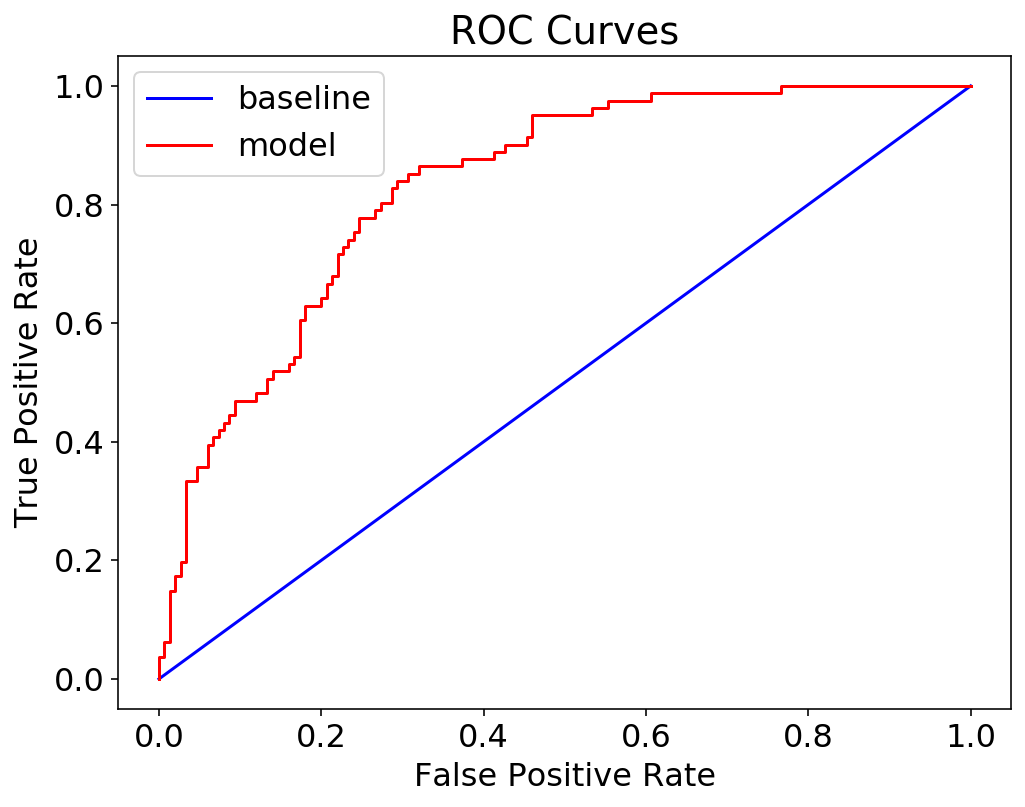

In [20]:
evaluate_model(test_svm_predictions, test_svm_probs,train_svm_predictions,train_svm_probs)

And finally, I will print out a classification report, to see what the recall and precision are with these models.

In [21]:
print(classification_report(test_labels,test_svm_predictions))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       150
           1       0.67      0.52      0.58        81

   micro avg       0.74      0.74      0.74       231
   macro avg       0.72      0.69      0.70       231
weighted avg       0.73      0.74      0.73       231



Hyper parameter tuning K-NN algorithm, to see which amount of neighbors gives the best results. It seems that around 23 neighbors is the sweet spot.

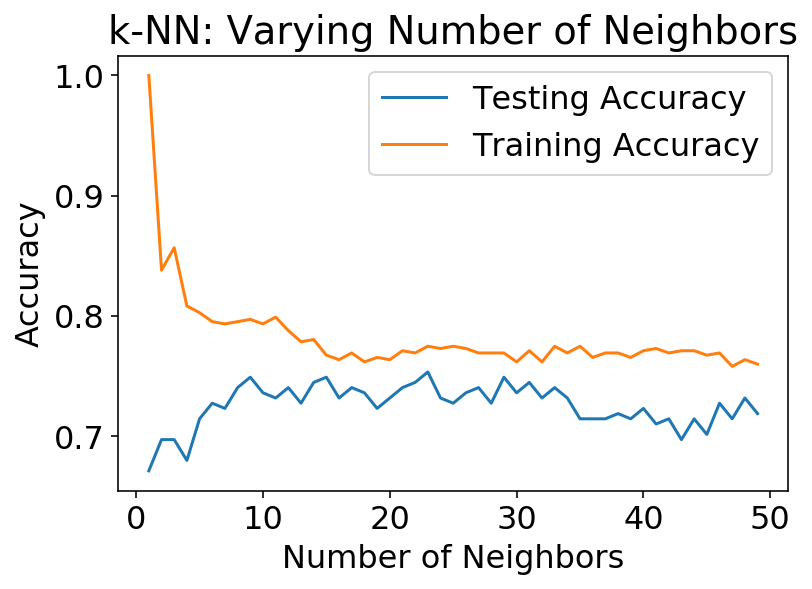

In [22]:

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 50)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(train, train_labels)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(train, train_labels)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(test, test_labels)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [23]:
knn = KNeighborsClassifier(n_neighbors=23)
knn.fit(train, train_labels)
test_knn_predictions = knn.predict(test)

Now I am going to evaluate these 2 models by comparing their scores to each other.

In [24]:
print("SVM")
print(classification_report(test_labels,test_svm_predictions))
print("K-NN")
print(classification_report(test_labels,test_knn_predictions))

SVM
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       150
           1       0.67      0.52      0.58        81

   micro avg       0.74      0.74      0.74       231
   macro avg       0.72      0.69      0.70       231
weighted avg       0.73      0.74      0.73       231

K-NN
              precision    recall  f1-score   support

           0       0.76      0.90      0.83       150
           1       0.72      0.48      0.58        81

   micro avg       0.75      0.75      0.75       231
   macro avg       0.74      0.69      0.70       231
weighted avg       0.75      0.75      0.74       231



After looking at precision, accuracy, and f-1 scores it seems K-NN is a slightly better performer here. It seems both models are very good at predicting true negatives. Let's take a final further look at the confusion matrices of these 2 models.

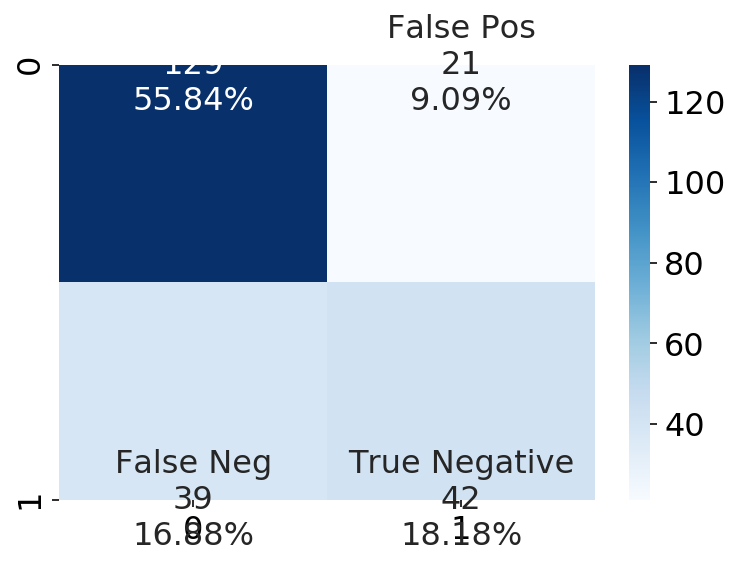

In [25]:
cm = confusion_matrix(test_labels, clf.predict(test)) 
group_names = ['True Neg','False Pos','False Neg','True Negative']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')


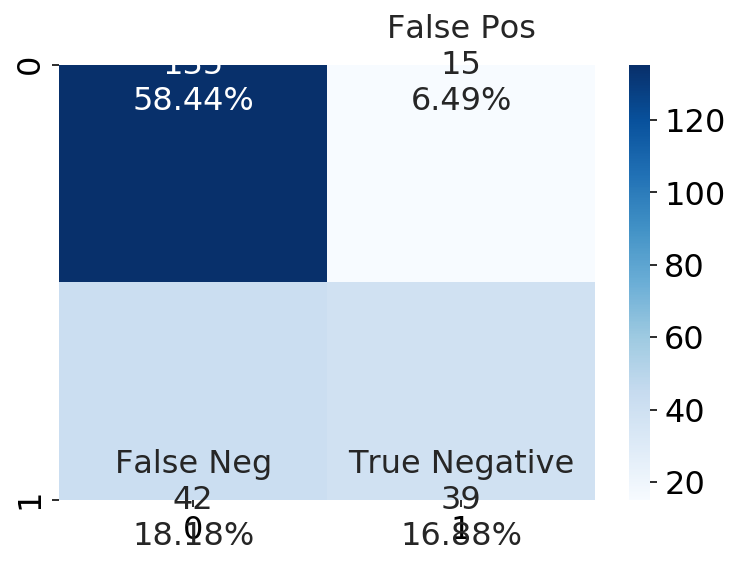

In [26]:
cm = confusion_matrix(test_labels, knn.predict(test)) 
group_names = ['True Neg','False Pos','False Neg','True Negative']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')


It seems that K-NN is slightly better at predicting 0's than SVM. About a 3% increase